In [2]:
# Install libraries
!pip install yfinance pandas numpy matplotlib seaborn

# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch data for Bitcoin as a demo; extendable to other assets
def fetch_data(ticker="BTC-USD", start="2020-01-01", end="2023-01-01"):
    data = yf.download(ticker, start=start, end=end)
    data['Returns'] = data['Adj Close'].pct_change()
    return data.dropna()

# Load data and view the first few rows
btc_data = fetch_data("BTC-USD")
print(btc_data.head())

[*********************100%***********************]  1 of 1 completed

Price                        Adj Close        Close         High          Low  \
Ticker                         BTC-USD      BTC-USD      BTC-USD      BTC-USD   
Date                                                                            
2020-01-02 00:00:00+00:00  6985.470215  6985.470215  7212.155273  6935.270020   
2020-01-03 00:00:00+00:00  7344.884277  7344.884277  7413.715332  6914.996094   
2020-01-04 00:00:00+00:00  7410.656738  7410.656738  7427.385742  7309.514160   
2020-01-05 00:00:00+00:00  7411.317383  7411.317383  7544.497070  7400.535645   
2020-01-06 00:00:00+00:00  7769.219238  7769.219238  7781.867188  7409.292969   

Price                             Open       Volume   Returns  
Ticker                         BTC-USD      BTC-USD            
Date                                                           
2020-01-02 00:00:00+00:00  7202.551270  20802083465 -0.029819  
2020-01-03 00:00:00+00:00  6984.428711  28111481032  0.051452  
2020-01-04 00:00:00+00:00  7345

In [3]:
# Add moving average indicators for the SMA crossover strategy
def add_indicators(data, short_window=20, long_window=50):
    data['SMA_Short'] = data['Adj Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Adj Close'].rolling(window=long_window).mean()
    data['Signal'] = np.where(data['SMA_Short'] > data['SMA_Long'], 1, -1)  # 1 for buy, -1 for sell
    return data

# Apply indicators to the data and view the last few rows
btc_data = add_indicators(btc_data)
print(btc_data[['Adj Close', 'SMA_Short', 'SMA_Long', 'Signal']].tail())

Price                         Adj Close     SMA_Short      SMA_Long Signal
Ticker                          BTC-USD                                   
Date                                                                      
2022-12-27 00:00:00+00:00  16717.173828  17004.295215  16846.066328      1
2022-12-28 00:00:00+00:00  16552.572266  16970.250098  16806.292344      1
2022-12-29 00:00:00+00:00  16642.341797  16945.709570  16821.523574      1
2022-12-30 00:00:00+00:00  16602.585938  16919.402637  16801.839863      1
2022-12-31 00:00:00+00:00  16547.496094  16891.567773  16792.103926      1


In [4]:
# Define backtesting function
def backtest(data, initial_capital=10000):
    data['Position'] = data['Signal'].shift()  # Hold the position from previous signal
    data['Strategy_Returns'] = data['Position'] * data['Returns']  # Calculate strategy returns
    data['Portfolio_Value'] = initial_capital * (1 + data['Strategy_Returns']).cumprod()  # Cumulative portfolio value
    return data

# Run backtest and calculate portfolio value over time
btc_data = backtest(btc_data)
print(btc_data[['Portfolio_Value', 'Strategy_Returns']].head())

Price                     Portfolio_Value Strategy_Returns
Ticker                                                    
Date                                                      
2020-01-02 00:00:00+00:00             NaN              NaN
2020-01-03 00:00:00+00:00     9485.483366        -0.051452
2020-01-04 00:00:00+00:00     9400.542125        -0.008955
2020-01-05 00:00:00+00:00     9399.704086        -0.000089
2020-01-06 00:00:00+00:00     8945.780531        -0.048291


In [5]:
# Define function to calculate performance metrics
def calculate_metrics(data):
    total_return = data['Portfolio_Value'].iloc[-1] / data['Portfolio_Value'].iloc[0] - 1
    annual_return = data['Strategy_Returns'].mean() * 252
    annual_volatility = data['Strategy_Returns'].std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    max_drawdown = ((data['Portfolio_Value'].cummax() - data['Portfolio_Value']) / data['Portfolio_Value'].cummax()).max()

    metrics = {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }
    return metrics

# Display calculated metrics
metrics = calculate_metrics(btc_data)
print("Strategy Metrics:", metrics)

Strategy Metrics: {'Total Return': nan, 'Annual Return': 0.2962120893457947, 'Annual Volatility': 0.6026670021004499, 'Sharpe Ratio': 0.49150208707863413, 'Max Drawdown': 0.6066133291714864}


In [6]:
from sklearn.model_selection import ParameterGrid

# Define optimization function
def optimize_parameters(data, param_grid, initial_capital=10000):
    best_sharpe = -np.inf
    best_params = None
    best_data = None

    for params in ParameterGrid(param_grid):
        test_data = add_indicators(data.copy(), **params)
        test_data = backtest(test_data, initial_capital=initial_capital)
        test_metrics = calculate_metrics(test_data)

        if test_metrics['Sharpe Ratio'] > best_sharpe:
            best_sharpe = test_metrics['Sharpe Ratio']
            best_params = params
            best_data = test_data

    return best_params, best_data

# Define parameter grid and optimize
param_grid = {
    "short_window": [10, 20, 30],
    "long_window": [50, 100, 150]
}

best_params, optimized_data = optimize_parameters(btc_data, param_grid)
print("Best Parameters:", best_params)

Best Parameters: {'long_window': 50, 'short_window': 10}


In [8]:
# Define risk management function
def apply_risk_management(data, initial_capital=10000, stop_loss=0.05, take_profit=0.1):
    """
    Applies risk management rules to the trading strategy.

    Args:
        data (pd.DataFrame): DataFrame containing trading data.
        initial_capital (float): Starting capital for the strategy.
        stop_loss (float): Percentage drawdown to trigger a stop-loss.
        take_profit (float): Percentage gain to trigger a take-profit.

    Returns:
        pd.DataFrame: DataFrame with updated portfolio value after applying risk management.
    """
    data['Peak'] = data['Portfolio_Value'].cummax()
    data['Drawdown'] = (data['Portfolio_Value'] - data['Peak']) / data['Peak']
    data['Stop_Loss_Signal'] = data['Drawdown'] < -stop_loss  # Stop-loss trigger
    data['Take_Profit_Signal'] = data['Strategy_Returns'] > take_profit  # Take-profit trigger

    # Update strategy returns to reflect exits
    data.loc[data['Stop_Loss_Signal'] | data['Take_Profit_Signal'], 'Strategy_Returns'] = 0
    data['Portfolio_Value'] = initial_capital * (1 + data['Strategy_Returns']).cumprod() # Use the passed initial_capital
    return data

# Apply risk management and re-run the backtest
btc_data = apply_risk_management(btc_data) # initial_capital is now a default argument
btc_data = backtest(btc_data)

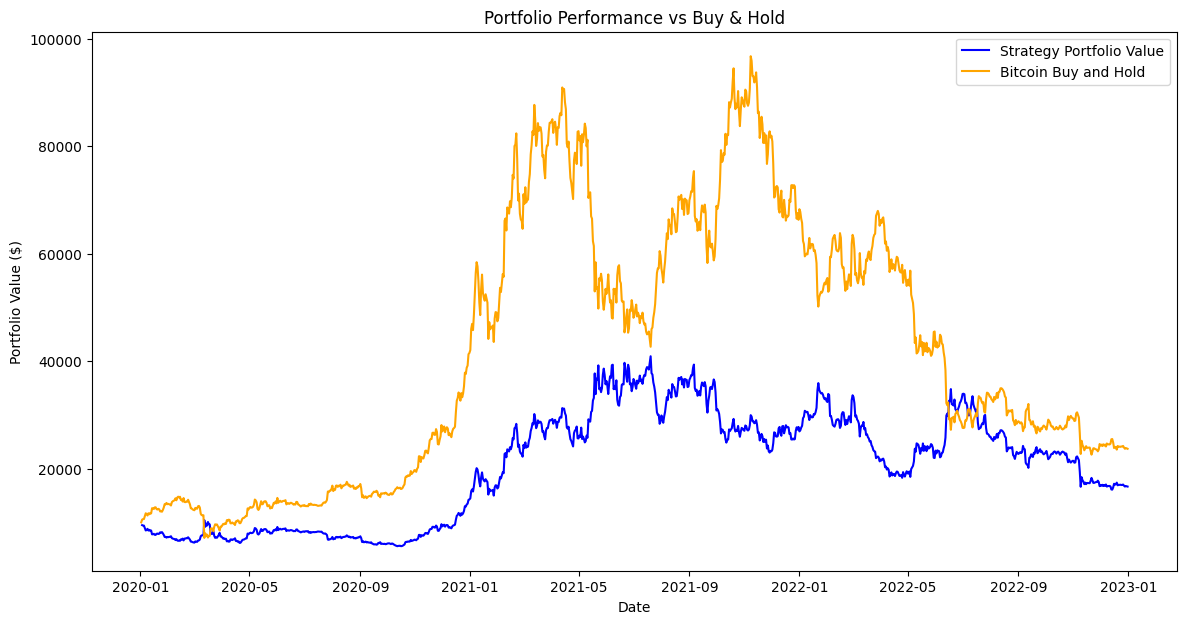

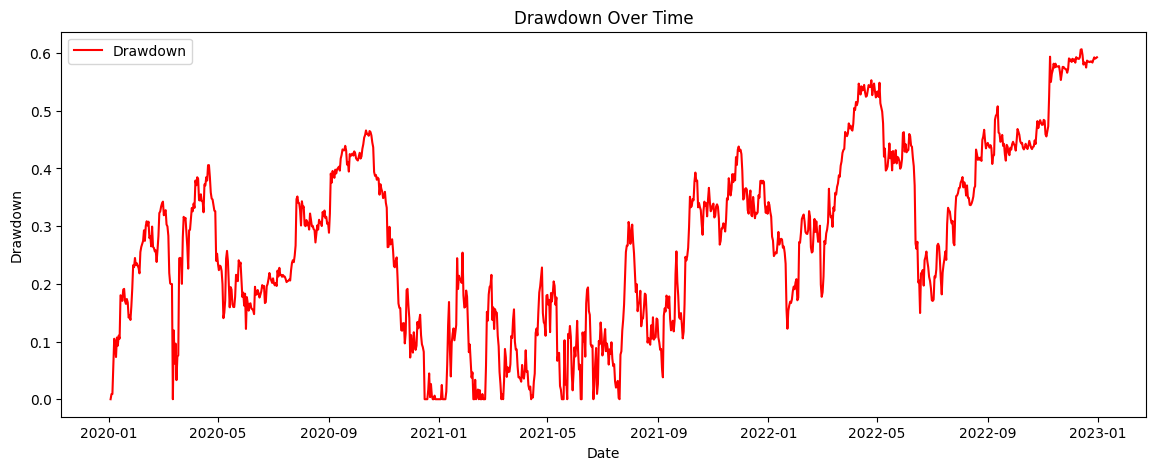

Final Strategy Metrics: {'Total Return': nan, 'Annual Return': 0.2962120893457947, 'Annual Volatility': 0.6026670021004499, 'Sharpe Ratio': 0.49150208707863413, 'Max Drawdown': 0.6066133291714864}


In [9]:
# Function to plot performance and drawdowns
def plot_performance(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Portfolio_Value'], label="Strategy Portfolio Value", color='blue')
    plt.plot(data.index, data['Adj Close'] / data['Adj Close'].iloc[0] * 10000, label="Bitcoin Buy and Hold", color='orange')
    plt.title("Portfolio Performance vs Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.show()

    # Plot drawdowns
    plt.figure(figsize=(14, 5))
    data['Drawdown'] = (data['Portfolio_Value'].cummax() - data['Portfolio_Value']) / data['Portfolio_Value'].cummax()
    sns.lineplot(x=data.index, y=data['Drawdown'], color="red", label="Drawdown")
    plt.title("Drawdown Over Time")
    plt.ylabel("Drawdown")
    plt.xlabel("Date")
    plt.legend()
    plt.show()

# Display results and plots
plot_performance(btc_data)
print("Final Strategy Metrics:", calculate_metrics(btc_data))